**PART 4. - Evaluation of classifier algorithms**

This part requires the use of machine learning for the project. For this exercise, we are going to use two different algorithms to train the machine. The first one will be a regression model, and the second one will use Naive Bayes. After checking different sources, the recommendations for a reliable small dataset, with strings as text to analyze and classify, is the use of a Naive Bayes classifier. Since we don’t know how they will perform with the sample, we are going to use both and try to compare them to find the best approach. We are going to prove the power of these classification algorithms to handle the data coded by GPT, and this is one of the main objectives of the project: to evaluate these algorithms' capacity to handle the data from GPT. The database we are going to use is a battery of more than 2 million tweets. Those tweets were sanitized, and then GPT coded a subsample of those tweets to train and validate the algorithm. We created two different types of variables: one was nominal, classifying the tweet's ideological content from left to right. Since their output is binary, we are going to call this the binary experiment for the *pole-label* column of data, for logistic regression and Naive Bayes approach. The other type of variable is a polarization score, from -7 to +7, among ranks of higher polarization from left to right for the *pol_score* column of the data. These algorithms are going to be evaluated also with a regression and Naive Bayes approach. There is another model approach, this time by using BERT models and LightGBM, since this approach requires different variables; it is handled in a separate notebook called BERT_LightGBM.

**Structure:**

Library: Imports libraries from scikit-learn for model building, including TfidfVectorizer, Pipeline, LogisticRegression, MultinomialNB, Ridge, and various metrics like classification_report and mean_squared_error.

Data: Loads the GPT-4 labeled dataset.

Binary classification: The data is filtered to include only "left" and "right" labeled tweets. These labels are mapped to 0 and 1, and the data is split into training and testing sets.

Multi-Class: The polar_score column is cleaned to handle invalid entries and rare classes are grouped. The data is then split for this task.

Model 1: Binary Logistic Regression on the column that classifies left and right tweets: A Pipeline is created that combines TfidfVectorizer (to convert text to numerical features) and LogisticRegression. The model is trained, and its performance is evaluated on the test set using a classification_report and a confusion matrix. 5-fold cross-validation is performed to assess the model's generalizability.

Model 2: Binary Naive Bayes on the column that classifies left and right tweets: A similar Pipeline is created, this time with a MultinomialNB classifier. The model is trained, evaluated, and cross-validated in the same manner as the logistic regression model.

Model 3 & 4: Multi-Class & Regression on the column that gives a scores of polarization form -7 to +7, polar_score: A MultinomialNB classifier is trained to predict the discrete polarization scores and evaluated. A Ridge regression model is trained to predict the polarization score as a continuous value. Its performance is measured with Mean Squared Error (MSE) and visualized with a scatter plot comparing actual vs. predicted values.

In [19]:
# Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import mord
from sklearn.preprocessing import LabelEncoder

In [20]:
# We start by loading the labeled tweet data (this is the output form part 2, we did it with GPT)
df_full = pd.read_csv("data/sample/debate_tweets_sample_1000_for_annotation_labeled.csv")
# Print the shape of the df
print(f"Dataset Shape: {df_full.shape}\n")

# Print the list of column names
print("Column Names:")
print(df_full.columns.tolist())

# Display a  summary of the df
print("\nData Structure and Types:")
df_full.info()

# Calculate and display missing values for each column
print("\nMissing Value Counts:")
print(df_full.isnull().sum())


# Analysis of the 'pole_label' column
# This is our target for the simple left/right/neutral classification.
print("\nDistribution of the 'pole_label' column:")
print(df_full['pole_label'].value_counts())


# Analysis of the 'polar_score' column
# This is our target for the more granular multiclass and regression models.
print("\nDistribution of the 'polar_score' column:")
print(df_full['polar_score'].value_counts().sort_index())


Dataset Shape: (1000, 29)

Column Names:
['Id', 'Date', 'Time', 'Media Type', 'Site Domain', 'Mention URL', 'Publisher Name', 'Publisher Username', 'title', 'Mention Content', 'Topics', 'Subtopics', 'Classifiers', 'Classifiers tags', 'Sentiment', 'Potential Reach', 'Engagement Rate', 'Interactions Total', 'Earned Media Value', 'Twitter Retweets', 'Twitter Favorites', 'Twitter replies', 'Media URL', 'Debate', 'santext', 'polar_score', 'pole_label', 'valid', 'comments']

Data Structure and Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  1000 non-null   int64  
 1   Date                1000 non-null   object 
 2   Time                1000 non-null   object 
 3   Media Type          1000 non-null   object 
 4   Site Domain         1000 non-null   object 
 5   Mention URL         1000 non-null   object 
 6

**PART 1. MODEL COMPETITION FOR THE POLARIZATION LABEL CLASSIFIERS pole_label**

**MODEL 1: BINARY WITH LOG REGRESSSION**

In [21]:
# clean the code for the binary model 1
# Start from the full dataframe and filter for our desired variable and classes
df_binary = df_full[df_full['pole_label'].isin(['left', 'right'])].copy()

# Convert categorical labels to numeric (0 for left, 1 for right)
label_map_binary = {'left': 0, 'right': 1}
df_binary['label'] = df_binary['pole_label'].map(label_map_binary)

# Train-test split (80/20), stratified to maintain the ratio of left/right tweets
# We use new variable names (e.g., X_train_bin) to keep our data splits separate for each model
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    df_binary['santext'], df_binary['label'],
    test_size=0.2,
    random_state=42,
    stratify=df_binary['label']
)

print(f"Data prepared for binary classification.")
print(f"Training set size: {len(X_train_bin)} tweets")
print(f"Test set size: {len(X_test_bin)} tweets")

Data prepared for binary classification.
Training set size: 700 tweets
Test set size: 175 tweets



 Logistic Regression Evaluation (Left vs. Right)

              precision    recall  f1-score   support

        left       0.70      0.78      0.74        90
       right       0.73      0.65      0.69        85

    accuracy                           0.71       175
   macro avg       0.72      0.71      0.71       175
weighted avg       0.72      0.71      0.71       175



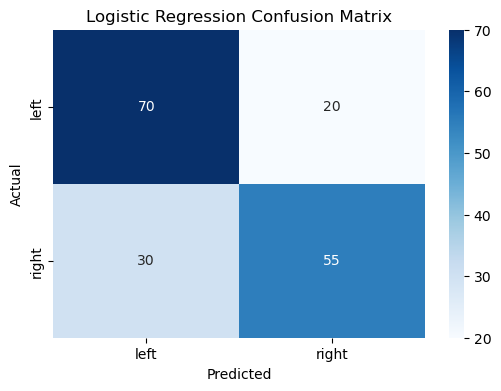

In [22]:
# Define a pipeline: TF-IDF + Logistic Regression
logreg_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1, 2))),
    # Use class_weight='balanced' to handle any potential imbalance between left/right classes
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

# Train the model
logreg_pipeline.fit(X_train_bin, y_train_bin)

# Make predictions on the test set
y_pred_logreg = logreg_pipeline.predict(X_test_bin)

# Evaluation
print("\n Logistic Regression Evaluation (Left vs. Right)\n")
print(classification_report(y_test_bin, y_pred_logreg, target_names=['left', 'right']))

# Visualize the Confusion matrix
cm_logreg = confusion_matrix(y_test_bin, y_pred_logreg)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_logreg, annot=True, fmt='d',
            xticklabels=['left', 'right'], yticklabels=['left', 'right'],
            cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

In [23]:
# cross validation of the model
# We can re-use the logreg_pipeline we already trained in Part 2
# and the df_binary dataframe.

# Perform 5-fold cross-validation on the Logistic Regression pipeline
cv_scores_logreg = cross_val_score(logreg_pipeline, df_binary['santext'], df_binary['label'], cv=5)

print("\n Logistic Regression Cross-Validation Scores ")
print(f"Scores for each of the 5 folds: {cv_scores_logreg}")
print(f"Mean CV Score: {cv_scores_logreg.mean():.4f}")
print(f"CV Score Standard Deviation: {cv_scores_logreg.std():.4f}")


 Logistic Regression Cross-Validation Scores 
Scores for each of the 5 folds: [0.81142857 0.76571429 0.66285714 0.74857143 0.71428571]
Mean CV Score: 0.7406
CV Score Standard Deviation: 0.0499


**MODEL 2. BINARY CLASSIFICATION (Left vs. Right) WITH NAIVE BAYES**


 Naive Bayes Evaluation (Left vs.. Right) 

              precision    recall  f1-score   support

        left       0.72      0.86      0.78        90
       right       0.81      0.65      0.72        85

    accuracy                           0.75       175
   macro avg       0.76      0.75      0.75       175
weighted avg       0.76      0.75      0.75       175



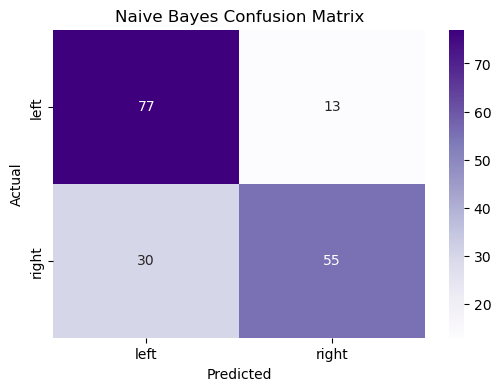

In [24]:
#train evaluate the naive bayes
# Define a new pipeline for the Naive Bayes model
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1, 2))),
    ('clf', MultinomialNB())
])

# Train the Naive Bayes model
nb_pipeline.fit(X_train_bin, y_train_bin)

# Make predictions on the test set
y_pred_nb = nb_pipeline.predict(X_test_bin)

# Evaluation
print("\n Naive Bayes Evaluation (Left vs.. Right) \n")
print(classification_report(y_test_bin, y_pred_nb, target_names=['left', 'right']))

# Visualize the Confusion matrix
cm_nb = confusion_matrix(y_test_bin, y_pred_nb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_nb, annot=True, fmt='d',
            xticklabels=['left', 'right'], yticklabels=['left', 'right'],
            cmap='Purples')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Naive Bayes Confusion Matrix')
plt.show()

In [25]:
#crossevaluation of the model
# Perform 5-fold cross-validation on the entire binary dataset
# cross_val_score handles the splitting automatically
cv_scores = cross_val_score(nb_pipeline, df_binary['santext'], df_binary['label'], cv=5)

print("\n Naive Bayes Cross-Validation Scores ")
print(f"Scores for each of the 5 folds: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f}")
print(f"CV Score Standard Deviation: {cv_scores.std():.4f}")


 Naive Bayes Cross-Validation Scores 
Scores for each of the 5 folds: [0.82285714 0.78857143 0.70857143 0.77714286 0.72571429]
Mean CV Score: 0.7646
CV Score Standard Deviation: 0.0419


**PART 2 - MODEL COMPETITION FOR POLAR SCORES**

Correction of the model for polar scores, try new classifiers

**MODEL 3. MULTICLASS CLASSIFICATION (Polarization Score) WITHG NAIVE BAYES**

In [26]:
# data preparation for this model since we are using diferent variables
# Filter out 'INV' rows
df_multi = df_full[df_full['polar_score'] != 'INV'].copy()

# Convert the 'polar_score' column to a numeric type
df_multi['polar_score'] = pd.to_numeric(df_multi['polar_score'])

# Group rare classes to ensure each class has enough members for training
# We'll group scores <= -6 into a single '-6' category, and scores >= 6 into a '+6' category.
df_multi.loc[df_multi['polar_score'] <= -6, 'polar_score'] = -6
df_multi.loc[df_multi['polar_score'] >= 6, 'polar_score'] = 6

print(" Value counts of 'polar_score' AFTER grouping rare classes")
print(df_multi['polar_score'].value_counts().sort_index())

# Now we can safely split the data, stratifying on our cleaned labels
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    df_multi['santext'], df_multi['polar_score'],
    test_size=0.2,
    random_state=42,
    stratify=df_multi['polar_score']
)

 Value counts of 'polar_score' AFTER grouping rare classes
polar_score
-6      5
-5    163
-3    211
-2     72
 0     33
 1      8
 2     76
 3     18
 4      8
 5    243
 6     71
Name: count, dtype: int64



 Multiclass Naive Bayes Evaluation (Polarization Score)

              precision    recall  f1-score   support

          -6       0.00      0.00      0.00         1
          -5       0.56      0.15      0.24        33
          -3       0.46      0.52      0.49        42
          -2       0.00      0.00      0.00        14
           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         1
           5       0.38      0.98      0.55        49
           6       0.00      0.00      0.00        14

    accuracy                           0.41       182
   macro avg       0.13      0.15      0.12       182
weighted avg       0.31      0.41      0.30       182



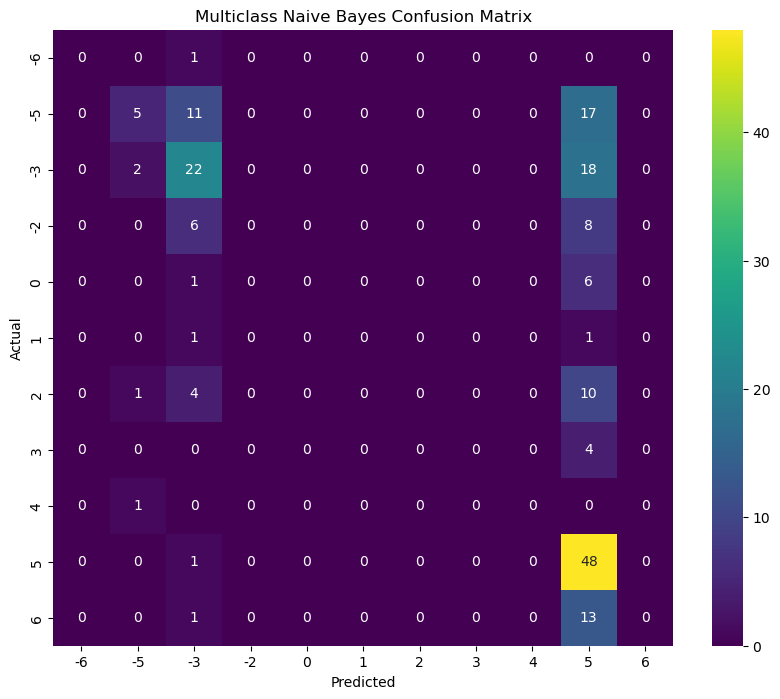

In [27]:
# Define a new pipeline for the multiclass classification task
nb_multi_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1, 2))),
    ('clf', MultinomialNB())
])

# Train the model
# Note: MultinomialNB works best with non-negative features. While TF-IDF is non-negative, the labels here are negative.
# This will still work, but other classifiers might be better suited. We proceed for comparison purposes.
nb_multi_pipeline.fit(X_train_multi, y_train_multi)

# Make predictions
y_pred_multi = nb_multi_pipeline.predict(X_test_multi)

# Evaluation
# Get the unique labels that are actually in our dataset for the report
labels = sorted(y_train_multi.unique())
target_names = [str(label) for label in labels]

print("\n Multiclass Naive Bayes Evaluation (Polarization Score)\n")
# Use zero_division=0 to prevent warnings if a class in the test set has no predictions
print(classification_report(y_test_multi, y_pred_multi, target_names=target_names, zero_division=0))


# Visualize the Confusion matrix
cm_multi = confusion_matrix(y_test_multi, y_pred_multi, labels=labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_multi, annot=True, fmt='d',
            xticklabels=target_names, yticklabels=target_names,
            cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Multiclass Naive Bayes Confusion Matrix')
plt.show()

**MODEL 4. Polarization score with regression (ridge)**

In [28]:
# We can re-use the exact same data split from the multiclass model
# X_train_multi, X_test_multi, y_train_multi, y_test_multi

# Define a pipeline using a Ridge regressor
ridge_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1, 2))),
    ('reg', Ridge())  # Using Ridge regression model
])

# Train the regression model
ridge_pipeline.fit(X_train_multi, y_train_multi)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=3000, ngram_range=(1, 2))),
                ('reg', Ridge())])


 Ridge Regression Evaluation 
Mean Squared Error (MSE): 10.8210


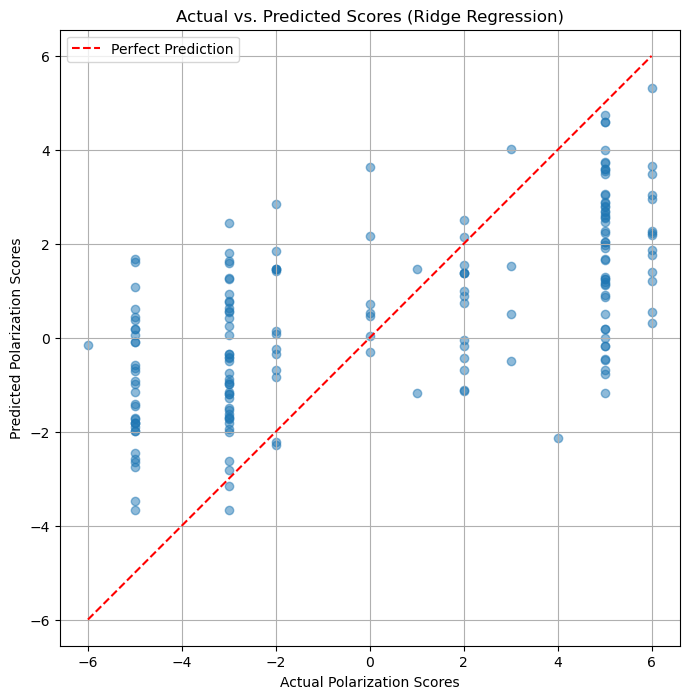

In [29]:
# Make predictions on the test set. These will be continuous values.
y_pred_ridge = ridge_pipeline.predict(X_test_multi)

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test_multi, y_pred_ridge)

print(f"\n Ridge Regression Evaluation ")
print(f"Mean Squared Error (MSE): {mse:.4f}")

# Visualization
# A scatter plot is a great way to see how the predictions line up with actual values
plt.figure(figsize=(8, 8))
plt.scatter(y_test_multi, y_pred_ridge, alpha=0.5)

# Add a line representing the lineal prediction (y=x)
perfect_line = np.linspace(min(y_test_multi), max(y_test_multi), 100)
plt.plot(perfect_line, perfect_line, color='red', linestyle='--', label='Perfect Prediction')

plt.xlabel("Actual Polarization Scores")
plt.ylabel("Predicted Polarization Scores")
plt.title("Actual vs. Predicted Scores (Ridge Regression)")
plt.legend()
plt.grid(True)
plt.axis('equal') # Ensures the x and y axes have the same scale for a true perspective
plt.show()

**MODEL 5. LightGBM Classifier for Polarization Level**

In [30]:
#First we need to be sure lightgbm is isntalled
#!pip install lightgbm

In [33]:
# We start with the df_multi dataframe
# It's already cleaned of 'INV' scores and has a numeric polar_score column.

# Define a function to map the numeric scores to the new categories
def get_polarization_level(score):
    score = int(score) # Ensure score is an integer
    if score in [-7, -6, 6, 7]:
        return 'High'
    elif score in [-5, -4, 4, 5]:
        return 'Medium'
    elif score in [-3, -2, 2, 3]:
        return 'Low'
    elif score in [-1, 0, 1]:
        return 'None'
    return None # Should not happen with our data

# Create the new 'polarization_level' column by applying the function
df_multi['polarization_level'] = df_multi['polar_score'].apply(get_polarization_level)

print(" Value counts of our new 4-category target variable ")
print(df_multi['polarization_level'].value_counts())

#  Create a new Train/Test Split for this task 
# We define an explicit order for our labels, which will be useful for ordinal modeling
category_order = ['None', 'Low', 'Medium', 'High']

# Stratify on our new 4-category label to ensure balanced splits
X_train_level, X_test_level, y_train_level, y_test_level = train_test_split(
    df_multi['santext'],
    df_multi['polarization_level'],
    test_size=0.2,
    random_state=42,
    stratify=df_multi['polarization_level']
)

print(f"\nData prepared for 4-level polarization classification.")
print(f"Training set size: {len(X_train_level)} tweets")
print(f"Test set size: {len(X_test_level)} tweets")

 Value counts of our new 4-category target variable 
polarization_level
Medium    414
Low       377
High       76
None       41
Name: count, dtype: int64

Data prepared for 4-level polarization classification.
Training set size: 726 tweets
Test set size: 182 tweets


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3349
[LightGBM] [Info] Number of data points in the train set: 726, number of used features: 145
[LightGBM] [Info] Start training from score -2.476676
[LightGBM] [Info] Start training from score -0.880440
[LightGBM] [Info] Start training from score -0.785432
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


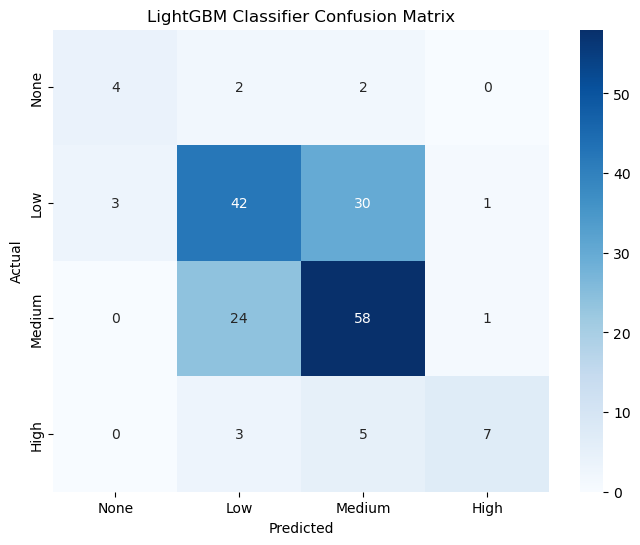

In [35]:
from lightgbm import LGBMClassifier

# Define the LightGBM pipeline
lgbm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1, 2))),
    ('clf', LGBMClassifier(random_state=42))
])

# Train the model
lgbm_pipeline.fit(X_train_level, y_train_level)

# Make predictions
y_pred_lgbm = lgbm_pipeline.predict(X_test_level)

#  Evaluation 
print("\n LightGBM Classifier Evaluation (Polarization Level) \n")
# Use the 'labels' parameter to ensure the report follows our desired order
print(classification_report(y_test_level, y_pred_lgbm, labels=category_order))

# Visualize the Confusion Matrix
cm_lgbm = confusion_matrix(y_test_level, y_pred_lgbm, labels=category_order)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lgbm, annot=True, fmt='d',
            xticklabels=category_order, yticklabels=category_order,
            cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LightGBM Classifier Confusion Matrix')
plt.show()

**CHAMPION MODEL OF PART 1: POLAR_LABEL**

Save the model for the first binary with best results

In [36]:
# Re-define our final Naive Bayes pipeline
final_binary_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1, 2))),
    ('clf', MultinomialNB())
])

# Train the final model on ALL the binary data (left and right)
# We use the full df_binary['santext'] and df_binary['label']
final_binary_pipeline.fit(df_binary['santext'], df_binary['label'])

# Save the trained pipeline to a file with a descriptive name
binary_model_filename = 'binary_classifier_nb_final.pkl'
joblib.dump(final_binary_pipeline, binary_model_filename)

print(f"Final Naive Bayes binary model has been trained on {len(df_binary)} tweets.")
print(f"Model saved successfully as '{binary_model_filename}'")

Final Naive Bayes binary model has been trained on 875 tweets.
Model saved successfully as 'binary_classifier_nb_final.pkl'


In [37]:
# Configuration
# This is the large dataset we want to apply the model to.
full_dataset_path = "data/all_debate_tweets_classified.csv"
# This is the trained model file we saved in the previous step.
binary_model_filename = 'binary_classifier_nb_final.pkl'
# This is the final output file that will contain the new predictions.
output_filename = 'debate_tweets_classified.csv'


# Load Data and Model
print(f"Loading full dataset from '{full_dataset_path}'...")
df_full = pd.read_csv(full_dataset_path, low_memory=False)

print(f"Loading saved binary model from '{binary_model_filename}'...")
loaded_binary_classifier = joblib.load(binary_model_filename)
print("Model loaded successfully")


#  Predict and Save 
print("\nApplying binary classifier to the full dataset")
# Use the loaded classifier to predict on the 'santext' column
# We need to ensure the santext column is clean of nulls first, just in case
binary_predictions = loaded_binary_classifier.predict(df_full['santext'].fillna(''))

# Add the predictions as a new column in our dataframe
df_full['predicted_binary_label_numeric'] = binary_predictions

# For better readability, map the numeric predictions (0, 1) back to text labels ('left', 'right')
reverse_binary_map = {0: 'left', 1: 'right'}
df_full['predicted_binary_label'] = df_full['predicted_binary_label_numeric'].map(reverse_binary_map)

# Save the full dataframe with the new binary predictions to the output CSV file
df_full.to_csv(output_filename, index=False)
print(f"Binary classification complete. Full dataset saved to '{output_filename}'")


#  Display Sample of Results 
# Display the first few rows with the original text and our new prediction.
print("\n Sample of Final Data with Binary Classification ")
print(df_full[['santext', 'predicted_binary_label']].head())

Loading full dataset from 'data/all_debate_tweets_classified.csv'...
Loading saved binary model from 'binary_classifier_nb_final.pkl'...
Model loaded successfully

Applying binary classifier to the full dataset
Binary classification complete. Full dataset saved to 'debate_tweets_classified.csv'

 Sample of Final Data with Binary Classification 
                                             santext predicted_binary_label
0  rt crnational president trump is the clear win...                  right
1  rt boloudon mattgaetz ronnyjacksontx president...                   left
2  rt rpsagainsttrump trump i didnt have sex with...                   left
3  rt nickknudsenus whoa wonder why the north ame...                  right
4  share this and then share this and then vote b...                  right


**CHAMPION MODEL FOR PART 2: POLAR_SCORES** 



In [38]:
# The champion model for polar_scores is LGBM
# We are going to try in the next notebook tgo get better the model by usign BERT for prepare the text
# Train, Save, and Apply the Final Polarization Level Model 